In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import seaborn as sns

In [2]:
# 读取数据
data = pd.read_csv(r'D:\ArcGISProjects\workspace\duyun\result_table\feature_dy.csv')
print(len(data))
# 删除有缺失值的行
# data.dropna(inplace=True)
# len(data),data.columns
# 填补缺失值为列均值
data.fillna(data.mean(),inplace=True)
len(data),data.columns

6498


(6498,
 Index(['pH', 'BIO', 'PRE', 'SRA', 'TMP', 'VAP', 'WIN', 'NDVI', 'TDQS', 'LIGHT',
        'AnalyticalHillshading', 'Aspect', 'ChannelNetworkBaseLevel',
        'ChannelNetworkDistance', 'ClosedDepressions', 'ConvergenceIndex',
        'LSFactor', 'PlanCurvature', 'ProfileCurvature',
        'RelativeSlopePosition', 'Slope', 'TopographicWetnessIndex',
        'TotalCatchmentArea', 'ValleyDepth', 'DEM', 'LON', 'LAT'],
       dtype='object'))

In [3]:
duplicates = data.duplicated(subset=list(data.columns)[1:], keep='first')
df_duplicates = data[duplicates]
df_duplicates

,pH,BIO,PRE,SRA,TMP,VAP,WIN,NDVI,TDQS,LIGHT,...,PlanCurvature,ProfileCurvature,RelativeSlopePosition,Slope,TopographicWetnessIndex,TotalCatchmentArea,ValleyDepth,DEM,LON,LAT
105,4.80,191.93000,100.250000,12975.583,15.575000,1.515000,1.650000,5937.2500,11,0.32,...,-0.010517,-0.013211,0.396114,0.543473,4.901549,551.45074,45.462402,950.89996,476870.0,2907905.0
128,5.10,188.68135,97.750000,12900.750,15.458333,1.515833,1.666667,5968.6665,12,0.39,...,-0.028547,-0.015172,0.211474,0.160172,7.596475,2090.75880,31.798462,889.70000,454680.0,2922765.0
183,5.74,190.44110,99.333336,12856.833,15.066667,1.475000,1.725000,5483.6665,12,0.48,...,0.000013,-0.001800,0.005022,0.044689,6.488055,197.16510,40.329346,979.40000,457915.0,2920865.0
323,5.78,190.74652,99.000000,12926.583,15.666667,1.525833,1.666667,6123.4165,12,0.39,...,0.000345,-0.003521,0.410191,0.099669,5.831614,170.45428,27.460205,858.30000,464675.0,2916150.0
346,5.86,190.64485,98.750000,12976.583,16.183334,1.568333,1.600000,4792.5835,11,1.31,...,-0.001112,-0.001239,0.084850,0.119835,7.140315,1072.52090,50.079956,732.50000,473200.0,2917010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5310,7.55,187.76186,97.333336,12947.417,15.350000,1.514167,1.741667,6855.8335,11,0.34,...,0.005515,-0.013658,0.345897,0.601815,4.369909,383.32740,65.071045,995.90000,422460.0,2901145.0
5444,4.98,188.65889,98.416664,12825.833,14.650000,1.452500,1.791667,6554.4165,14,0.39,...,0.003312,0.015443,0.735760,0.853928,3.622754,237.74886,16.855590,1220.50000,429215.0,2911980.0
5492,7.48,190.40323,100.000000,12813.500,14.125000,1.398333,1.858333,6345.7500,11,0.51,...,-0.003722,0.000826,0.102992,0.447609,5.632267,684.27527,90.968140,1217.50000,426920.0,2906950.0
6355,4.86,193.61485,100.166664,13168.500,17.083334,1.665833,1.550000,5654.9165,11,0.36,...,-0.005336,0.003686,0.157649,0.251648,5.986502,616.92570,50.888428,536.70000,475255.0,2879010.0


In [4]:
# 去除重复数据
data.drop_duplicates(subset=list(data.columns)[1:], keep='first', inplace=True)

In [5]:
data

,pH,BIO,PRE,SRA,TMP,VAP,WIN,NDVI,TDQS,LIGHT,...,PlanCurvature,ProfileCurvature,RelativeSlopePosition,Slope,TopographicWetnessIndex,TotalCatchmentArea,ValleyDepth,DEM,LON,LAT
0,7.00,190.86998,98.666664,13017.417,16.433334,1.590833,1.550000,4957.3335,11,0.38,...,0.000212,0.002410,0.098463,0.044694,5.466934,71.02434,63.278564,659.9,477615.0,2912145.0
1,6.26,190.86998,98.666664,13017.417,16.433334,1.590833,1.550000,4957.3335,11,0.44,...,0.001302,0.009316,0.173775,0.372854,4.767581,317.61050,38.721313,663.8,477545.0,2912550.0
2,5.00,190.69460,98.666664,13014.500,16.366667,1.585833,1.550000,5189.5835,11,0.29,...,0.001092,-0.001505,0.887517,0.199547,5.328438,237.03818,8.369263,809.8,477515.0,2911055.0
3,4.56,193.19330,101.250000,12963.917,15.275001,1.498333,1.675000,4545.4165,12,0.51,...,-0.001674,-0.001910,0.630447,0.119424,7.580021,1175.15450,5.527954,985.5,477550.0,2903650.0
4,5.26,193.27090,101.500000,12942.083,15.025000,1.472500,1.716667,4545.4165,12,0.49,...,-0.002633,0.001256,0.309874,0.121057,5.209813,128.14406,7.989014,1053.9,476955.0,2903835.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6493,4.28,194.32289,101.000000,13139.167,16.658333,1.623333,1.566667,6453.5000,11,0.37,...,0.001159,0.012776,0.793077,0.387316,4.872347,313.50446,10.220215,736.3,474855.0,2877650.0
6494,5.22,195.11249,101.750000,13106.833,16.283333,1.588333,1.625000,6453.5000,13,0.32,...,-0.001786,0.003725,0.189204,0.316963,8.056048,7251.41500,14.642578,783.0,474365.0,2877410.0
6495,4.64,193.37679,101.166664,13005.167,15.516666,1.518333,1.650000,5898.9165,11,0.46,...,0.006366,0.002606,0.079942,0.219988,6.338568,848.97815,88.750370,816.7,475230.0,2896000.0
6496,4.72,193.37679,101.166664,13005.167,15.516666,1.518333,1.650000,5898.9165,11,0.46,...,-0.014637,-0.026469,0.016656,0.556219,4.970899,598.25275,67.318240,873.2,475320.0,2895595.0


In [6]:
# data['DL'] = data['DL'].astype("str")
# data['DZ'] = data['DZ'].astype("str")
# data['SC'] = data['SC'].astype("category")
data['TDQS'] = data['TDQS'].astype("category")
data.dtypes

pH                          float64
BIO                         float64
PRE                         float64
SRA                         float64
TMP                         float64
VAP                         float64
WIN                         float64
NDVI                        float64
TDQS                       category
LIGHT                       float64
AnalyticalHillshading       float64
Aspect                      float64
ChannelNetworkBaseLevel     float64
ChannelNetworkDistance      float64
ClosedDepressions           float64
ConvergenceIndex            float64
LSFactor                    float64
PlanCurvature               float64
ProfileCurvature            float64
RelativeSlopePosition       float64
Slope                       float64
TopographicWetnessIndex     float64
TotalCatchmentArea          float64
ValleyDepth                 float64
DEM                         float64
LON                         float64
LAT                         float64
dtype: object

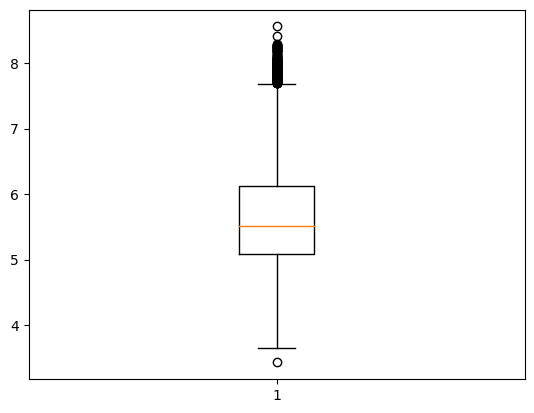

(6425, 27)


In [7]:
plt.boxplot(data["pH"])
plt.show()
print(data.shape)

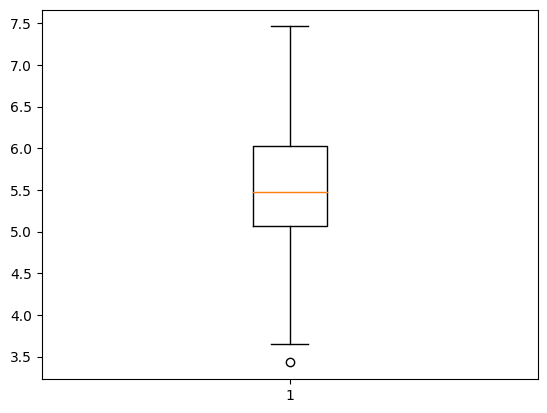

(6142, 27)


In [9]:
# 剔除离群值（Z-score）
z_scores = (data["pH"]-data["pH"].mean())/data["pH"].std()
z_scores.describe()
# 设置阈值
z_score_filter= 2.185
z_filter_data = data[z_scores<z_score_filter]
z_filter_data
plt.boxplot(z_filter_data["pH"])
plt.show()
print(z_filter_data.shape)

In [6]:
# 划分测试数据
train_data,test_data = train_test_split(data,test_size=0.2,random_state=0)
train_data.shape,test_data.shape

((5140, 27), (1285, 27))

In [10]:
# 划分测试数据
train_data,test_data = train_test_split(z_filter_data,test_size=0.2,random_state=0)
train_data.shape,test_data.shape

((4913, 27), (1229, 27))

In [7]:
label = 'pH'
train_data[label].describe()

count    5140.000000
mean        5.682021
std         0.821579
min         3.430000
25%         5.100000
50%         5.530000
75%         6.140000
max         8.560000
Name: pH, dtype: float64

In [8]:
# TabularPredictor.load("AutogluonModels\ag-20230802_083815\")  全要素
# TabularPredictor.load("AutogluonModels\ag-20230803_041226\")  全要素  presets="best_quality"

# predictor = TabularPredictor(label=label).fit(train_data,time_limit=6000,presets="best_quality")
# predictor = TabularPredictor.load(r"AutogluonModels\ag-20230803_041226")

# 模型存放位置
model_path = r'D:\ArcGISProjects\workspace\duyun\model_path\autogluon_model'
# model_path = r'D:\ArcgisData\pred_organic\organic_pred_moudle\对数化'
predictor = TabularPredictor(label=label,path=model_path,eval_metric='r2')
# predictor.fit(train_data,time_limit=10800,presets="best_quality",num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
# predictor.fit(train_data,time_limit=10800,num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
# predictor = TabularPredictor.load(model_path)
predictor.fit(train_data,time_limit=10800)

Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "D:\ArcGISProjects\workspace\duyun\model_path\autogluon_model\"
AutoGluon Version:  0.8.2
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
Disk Space Avail:   182.27 GB / 808.56 GB (22.5%)
Train Data Rows:    5140
Train Data Columns: 26
Label Column: pH
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (8.56, 3.43, 5.68202, 0.82158)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    28732.23 MB
	Train Data (Original

In [14]:
# 获取最佳模型
best_model = predictor.get_model_best()
print(best_model)

# 获取模型的训练摘要
predictor.fit_summary()

WeightedEnsemble_L2
*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.376111       0.065454  23.006822                0.000000           0.114867            2       True         12
1              CatBoost   0.362949       0.002595  16.498535                0.002595          16.498535            1       True          6
2         ExtraTreesMSE   0.346714       0.034356   0.320271                0.034356           0.320271            1       True          7
3         LightGBMLarge   0.336923       0.006531   1.408868                0.006531           1.408868            1       True         11
4              LightGBM   0.334924       0.002929   0.533402                0.002929           0.533402            1       True          4
5               XGBoost   0.332194       0.006006   0.743421                0.006006

d:\worker_code\.venvgis\lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT': 'LGBModel',
  'LightGBM': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'CatBoost': 'CatBoostModel',
  'ExtraTreesMSE': 'XTModel',
  'NeuralNetFastAI': 'NNFastAiTabularModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': 0.1838232932297812,
  'KNeighborsDist': 0.05991829755053446,
  'LightGBMXT': 0.33176244010765643,
  'LightGBM': 0.3349235335367561,
  'RandomForestMSE': 0.3314257278209177,
  'CatBoost': 0.36294891171273025,
  'ExtraTreesMSE': 0.34671392482081964,
  'NeuralNetFastAI': 0.2594084975807437,
  'XGBoost': 0.3321939508515793,
  'NeuralNetTorch': 0.25946612822319826,
  'LightGBMLarge': 0.33692349949751965,
  'WeightedEnsemble_L2': 0.3761106976932067},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif': '..\\

In [29]:
# 测试数据集
y_test_pred = predictor.predict(test_data.drop(columns=[label]))
y_test = test_data[label]
# 训练数据
y_train_pred = predictor.predict(train_data.drop(columns=[label]))
y_train = train_data[label]
# 计算残差
residuals_test =y_train - y_train_pred

In [15]:
predictor.leaderboard(train_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,0.872907,0.336923,0.011970,0.006531,1.408868,0.011970,0.006531,1.408868,1,True,11
1,ExtraTreesMSE,0.854419,0.346714,0.199820,0.034356,0.320271,0.199820,0.034356,0.320271,1,True,7
2,RandomForestMSE,0.852377,0.331426,0.225198,0.049455,1.096171,0.225198,0.049455,1.096171,1,True,5
3,LightGBMXT,0.731102,0.331762,0.027273,0.000000,1.161341,0.027273,0.000000,1.161341,1,True,3
4,WeightedEnsemble_L2,0.704914,0.376111,0.276508,0.065454,23.006822,0.015058,0.000000,0.114867,2,True,12
5,XGBoost,0.660952,0.332194,0.019648,0.006006,0.743421,0.019648,0.006006,0.743421,1,True,9
6,KNeighborsDist,0.638996,0.059918,0.006296,0.002516,0.005571,0.006296,0.002516,0.005571,1,True,2
7,CatBoost,0.631296,0.362949,0.000000,0.002595,16.498535,0.000000,0.002595,16.498535,1,True,6
8,LightGBM,0.598275,0.334924,0.007505,0.002929,0.533402,0.007505,0.002929,0.533402,1,True,4
9,KNeighborsUnif,0.444443,0.183823,0.005564,0.009348,2.667140,0.005564,0.009348,2.667140,1,True,1


,pH,BIO,PRE,SRA,TMP,VAP,WIN,NDVI,TDQS,LIGHT,...,PlanCurvature,ProfileCurvature,RelativeSlopePosition,Slope,TopographicWetnessIndex,TotalCatchmentArea,ValleyDepth,DEM,LON,LAT
1945,6.00,191.59576,99.333336,13008.750,16.075000,1.577500,1.608333,5096.5000,11,0.94,...,0.000268,-1.458035e-04,0.014486,0.020184,6.918693,103.72844,6.515259,750.8,455905.0,2897140.0
1109,5.56,194.97856,101.666664,13179.583,15.966666,1.576667,1.641667,7425.9165,12,0.31,...,-0.000095,-5.352268e-03,0.000000,0.029087,8.641477,1017.16120,141.100950,774.3,442950.0,2860965.0
2931,5.16,194.11765,101.250000,13038.083,16.100000,1.578333,1.616667,5245.2500,11,0.43,...,0.001142,-3.898207e-03,0.184138,0.235936,6.139693,695.85250,31.994507,724.7,472235.0,2888010.0
744,6.10,188.76027,98.250000,12923.833,15.150000,1.490833,1.733333,6194.7500,11,0.42,...,0.000692,1.333051e-04,0.645464,0.283687,5.002255,238.00266,18.238160,1085.6,423710.0,2899265.0
2242,5.31,191.69266,100.666664,12901.083,14.383333,1.422500,1.841667,5730.5000,11,0.29,...,-0.002968,-2.007133e-03,0.000000,0.036048,11.264549,19506.41800,64.549440,1204.3,416885.0,2886635.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,4.89,195.54823,102.416664,13140.667,15.600000,1.540833,1.683333,7344.5835,11,0.28,...,0.003347,-1.065377e-02,0.165277,0.646265,3.782306,232.76337,55.843018,854.5,444000.0,2861440.0
2590,4.74,192.35051,100.250000,13023.083,15.908334,1.559167,1.625000,4540.1665,12,0.43,...,0.000829,-4.168923e-04,0.836851,0.031612,5.283646,39.41985,3.988647,811.0,466900.0,2892500.0
5826,5.21,193.09457,101.583336,12936.833,14.658334,1.453333,1.808333,5421.4165,11,0.30,...,0.000038,8.475624e-07,0.011139,0.001562,9.580503,146.70598,41.278687,1114.2,417835.0,2875600.0
5411,5.63,189.37376,99.000000,12802.750,14.375000,1.429167,1.791667,6977.6665,14,0.39,...,-0.000149,-4.467989e-02,0.017259,0.502213,5.499754,929.59760,69.119630,1135.1,429745.0,2913425.0


In [16]:
predictor.leaderboard(test_data, silent=True)


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,0.327657,0.334924,0.004756,0.002929,0.533402,0.004756,0.002929,0.533402,1,True,4
1,WeightedEnsemble_L2,0.319650,0.376111,0.197389,0.065454,23.006822,0.000000,0.000000,0.114867,2,True,12
2,CatBoost,0.314226,0.362949,0.010512,0.002595,16.498535,0.010512,0.002595,16.498535,1,True,6
3,LightGBMXT,0.313119,0.331762,0.012461,0.000000,1.161341,0.012461,0.000000,1.161341,1,True,3
4,XGBoost,0.308447,0.332194,0.009992,0.006006,0.743421,0.009992,0.006006,0.743421,1,True,9
5,ExtraTreesMSE,0.307814,0.346714,0.154676,0.034356,0.320271,0.154676,0.034356,0.320271,1,True,7
6,LightGBMLarge,0.304666,0.336923,0.003005,0.006531,1.408868,0.003005,0.006531,1.408868,1,True,11
7,RandomForestMSE,0.301566,0.331426,0.197598,0.049455,1.096171,0.197598,0.049455,1.096171,1,True,5
8,NeuralNetTorch,0.251312,0.259466,0.016707,0.000000,6.611311,0.016707,0.000000,6.611311,1,True,10
9,NeuralNetFastAI,0.218871,0.259408,0.024497,0.016639,3.400438,0.024497,0.016639,3.400438,1,True,8


In [32]:

# 训练集指标
train_metrics = predictor.leaderboard(train_data, silent=True) 

# 测试集指标
test_metrics = predictor.leaderboard(test_data, silent=True)

# 获取指标名称
metric_name = list(train_metrics.keys())[0]  


In [33]:
pd_train = train_metrics[['model','score_test']]
pd_test = test_metrics[['model','score_test']]
pd_result = pd.merge(pd_train,pd_test,on='model')

In [34]:
pd_result
pd_result.rename(columns = {"model":"Model","score_test_x":"Train Set","score_test_y":"Test  Set"},inplace=True)

In [35]:
pd_result

,Model,Train Set,Test Set
0,RandomForestMSE,0.902758,0.286192
1,ExtraTreesMSE,0.902386,0.285661
2,LightGBMLarge,0.865258,0.273084
3,WeightedEnsemble_L2,0.729776,0.306607
4,XGBoost,0.642124,0.266571
5,CatBoost,0.628726,0.276279
6,LightGBMXT,0.574449,0.271458
7,LightGBM,0.526108,0.265652
8,KNeighborsDist,0.491149,0.052869
9,KNeighborsUnif,0.462486,0.176366


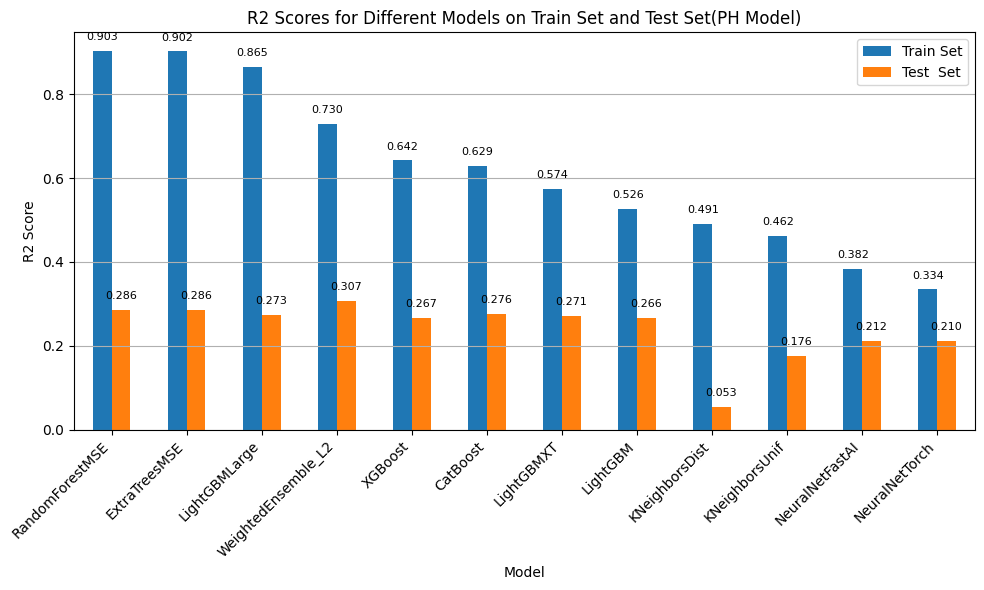

In [36]:
ax = pd_result.set_index('Model').plot(kind='bar', figsize=(10,6))
plt.title('R2 Scores for Different Models on Train Set and Test Set(PH Model)')
plt.ylabel('R2 Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')

# 添加数值标签
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points',fontsize=8, 
                )

plt.tight_layout()
plt.show()


In [40]:
# 克里金残差训练
OK = OrdinaryKriging(train_data['LON'], train_data['LAT'], residuals_test, variogram_model='spherical')  #variogram_model:linear,gaussian,exponential,spherical
kriging_predictions_test, _ = OK.execute('points', test_data['LON'], test_data['LAT'])
predictions_test = y_test_pred + kriging_predictions_test
# 计算R2
r2 = r2_score(y_test, predictions_test)
r2

0.31182508011332943

In [41]:
test_data.describe()

,pH,BIO,PRE,SRA,TMP,VAP,WIN,DEM,NDVI,LIGHT,LON,LAT,SLOPE,ASP,CUR,TWI3,TWI5,TPI3,TPI5
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1.917000e+03,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000
mean,5.670996,192.263590,100.410103,12967.962139,15.292853,1.506819,1.706960,953.320814,5766.719834,0.555175,448301.552833,2.893343e+06,10.909059,173.324478,-0.219092,4.342292,4.853118,100.071221,100.202893
std,0.805399,1.919623,1.391007,95.589259,0.706621,0.059899,0.086308,169.291890,626.382909,0.731063,17184.968697,1.575804e+04,7.658251,96.890662,0.818508,1.919739,1.919739,0.236669,0.446908
min,3.430000,187.548970,97.166664,12688.250000,12.566667,1.280000,1.525000,485.000000,3329.000000,0.200000,411965.340000,2.860765e+06,0.000000,-1.000000,-5.000000,1.392474,1.903300,98.926926,98.371400
25%,5.080000,191.044590,99.500000,12905.167000,14.941667,1.478333,1.650000,843.000000,5352.500000,0.320000,434045.340000,2.880505e+06,4.727943,95.194430,-0.555556,3.158444,3.669269,99.945930,99.939850
50%,5.540000,192.228670,100.333336,12979.500000,15.400001,1.514167,1.691667,925.000000,5810.166500,0.370000,448805.340000,2.893045e+06,9.421579,174.427800,-0.111111,3.988360,4.499185,100.047790,100.140060
75%,6.140000,193.258220,101.166664,13030.250000,15.750000,1.545833,1.750000,1035.000000,6195.916500,0.480000,462875.340000,2.906005e+06,15.439987,251.565050,0.222222,5.070351,5.581176,100.174866,100.425910
max,8.560000,200.715650,107.666664,13208.750000,17.333334,1.685833,2.066667,1680.000000,7615.083500,12.350000,477605.340000,2.923915e+06,48.120308,358.264280,4.666666,18.405981,18.916805,101.576980,102.600220


In [42]:
# 重新计算预测值

def calc_predict_value(actual_value, predict_value):
    diff = np.abs(actual_value - predict_value)/actual_value
    modified_diff = np.where(diff <= 0.15, actual_value, predict_value)
    return modified_diff


In [43]:
t_pred = calc_predict_value(test_data[label],y_test_pred)
t_pred

array([7.        , 4.67      , 5.90044641, ..., 4.94      , 4.2       ,
       5.39967299])

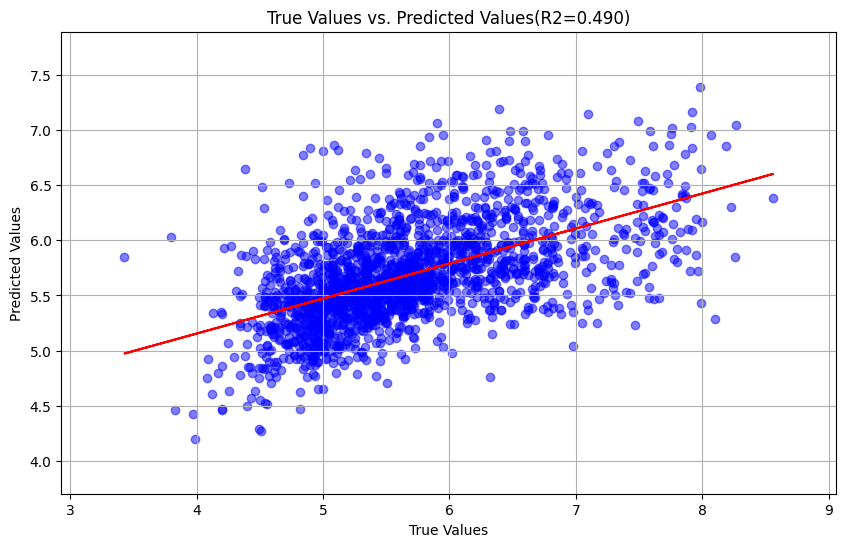

In [44]:
# plt.scatter(y_test, predictions_test)

# # 添加标签和标题
# plt.xlabel('True Values')
# plt.ylabel('Predicted Values')
# plt.title('True Values vs. Predicted Values')

# # 显示图表
# plt.show()
# 画图
plt.figure(figsize=(10,6))
plt.scatter(y_test, predictions_test, c='b', alpha=0.5)

fit = np.polyfit(y_test, predictions_test, deg=1)
fit_fn = np.poly1d(fit) 
plt.plot(y_test, fit_fn(y_test), c='r')

plt.xlim([min(y_test)-0.5, max(y_test)+0.5])
plt.ylim([min(predictions_test)-0.5, max(predictions_test)+0.5])
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values(R2=0.490)')
plt.grid()

plt.show()

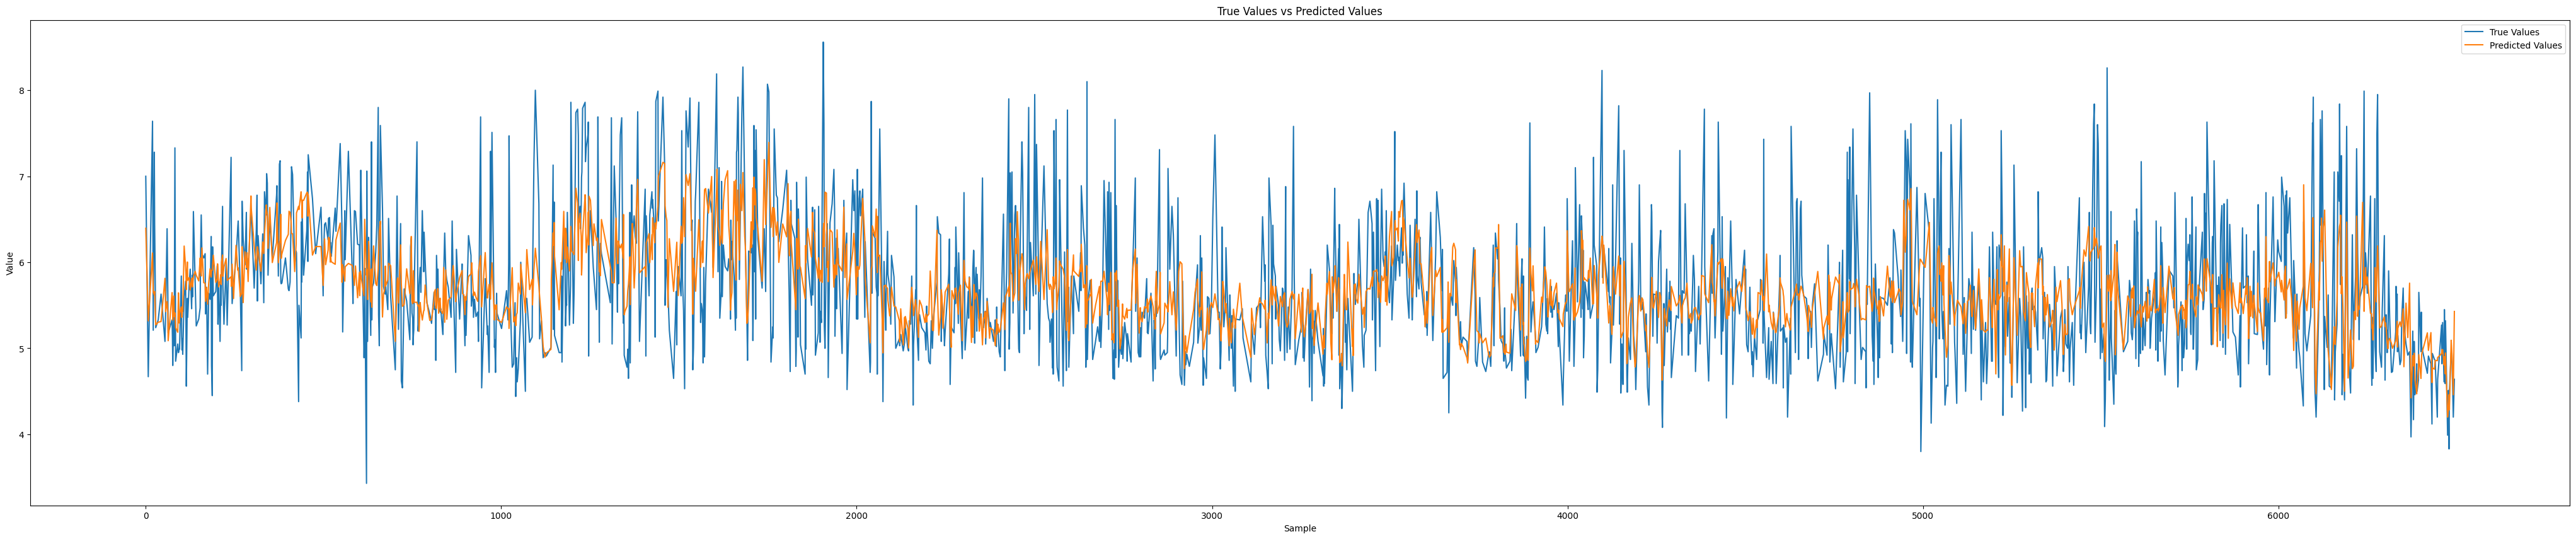

In [45]:
# 创建折线图
plt.figure(figsize=(52,10))
plt.plot(y_test, label='True Values')
plt.plot(predictions_test, label='Predicted Values')

# 图表标题和标签
plt.title('True Values vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [46]:
predictor.evaluate(test_data, silent=True)

{'r2': 0.30660720532057784,
 'root_mean_squared_error': -0.6704824883108231,
 'mean_squared_error': -0.449546767131473,
 'mean_absolute_error': -0.5055546286955561,
 'pearsonr': 0.5543911628204106,
 'median_absolute_error': -0.3895366096496584}

In [48]:
perf = predictor.evaluate_predictions(y_train,y_train_pred,auxiliary_metrics=True,detailed_report=True)

Evaluation: r2 on test data: 0.7297758533123591
Evaluations on test data:
{
    "r2": 0.7297758533123591,
    "root_mean_squared_error": -0.4270838139074082,
    "mean_squared_error": -0.18240058410169768,
    "mean_absolute_error": -0.32052812160114147,
    "pearsonr": 0.8976522504513782,
    "median_absolute_error": -0.23922473907470732
}


In [51]:
perf = predictor.evaluate_predictions(y_test,y_test_pred,auxiliary_metrics=True,detailed_report=True)

Evaluation: r2 on test data: 0.30660720532057784
Evaluations on test data:
{
    "r2": 0.30660720532057784,
    "root_mean_squared_error": -0.6704824883108231,
    "mean_squared_error": -0.449546767131473,
    "mean_absolute_error": -0.5055546286955561,
    "pearsonr": 0.5543911628204106,
    "median_absolute_error": -0.3895366096496584
}


In [52]:

def calculate_modified_r2(y_true, y_pred):
    diff = np.abs(y_true - y_pred)/y_true
    modified_diff = np.where(diff <= 0.2, 0, np.abs(y_true - y_pred))
    modified_ssr = np.sum(modified_diff**2)
    
    mean = np.mean(y_true)
    total_diff = np.sum((y_true - mean)**2)
    
    r2 = 1 - (modified_ssr / total_diff)
    return r2

print(calculate_modified_r2(test_data[label], y_test_pred))

0.6974848676843521


In [53]:
metrics = predictor.evaluate(test_data, silent=True)

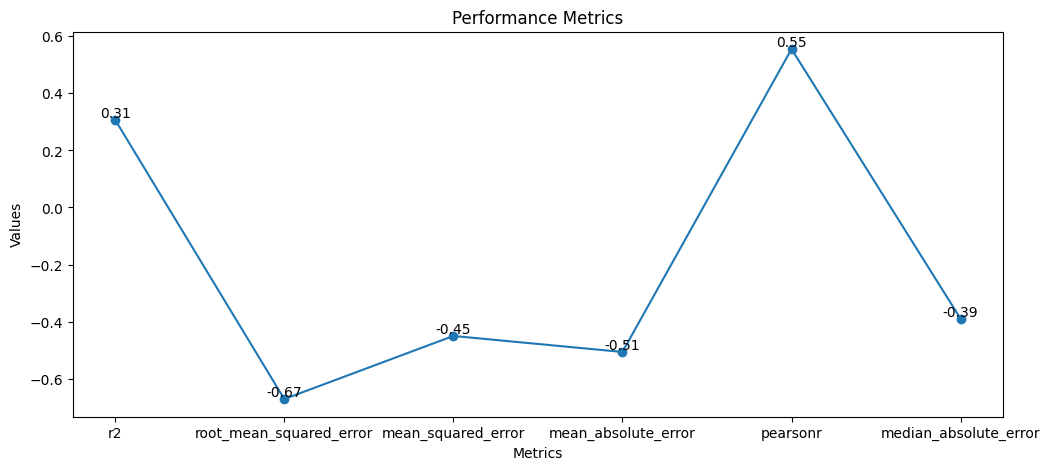

In [54]:
metric_names = list(metrics.keys())
metric_values = list(metrics.values())
plt.figure(figsize=(12,5))
plt.plot(metric_names, metric_values, marker='o')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics')

# 标注数值
for i in range(len(metric_names)):
    plt.annotate(f'{metric_values[i]:.2f}', (metric_names[i], metric_values[i]), ha='center', va='bottom')

plt.show()


In [55]:
fetures_value = predictor.feature_importance(train_data)
# 将索引添加为列

Computing feature importance via permutation shuffling for 19 features using 4473 rows with 5 shuffle sets...
	39.48s	= Expected runtime (7.9s per shuffle set)
	10.03s	= Actual runtime (Completed 5 of 5 shuffle sets)


In [56]:
df = fetures_value
df.reset_index(level=0, inplace=True)

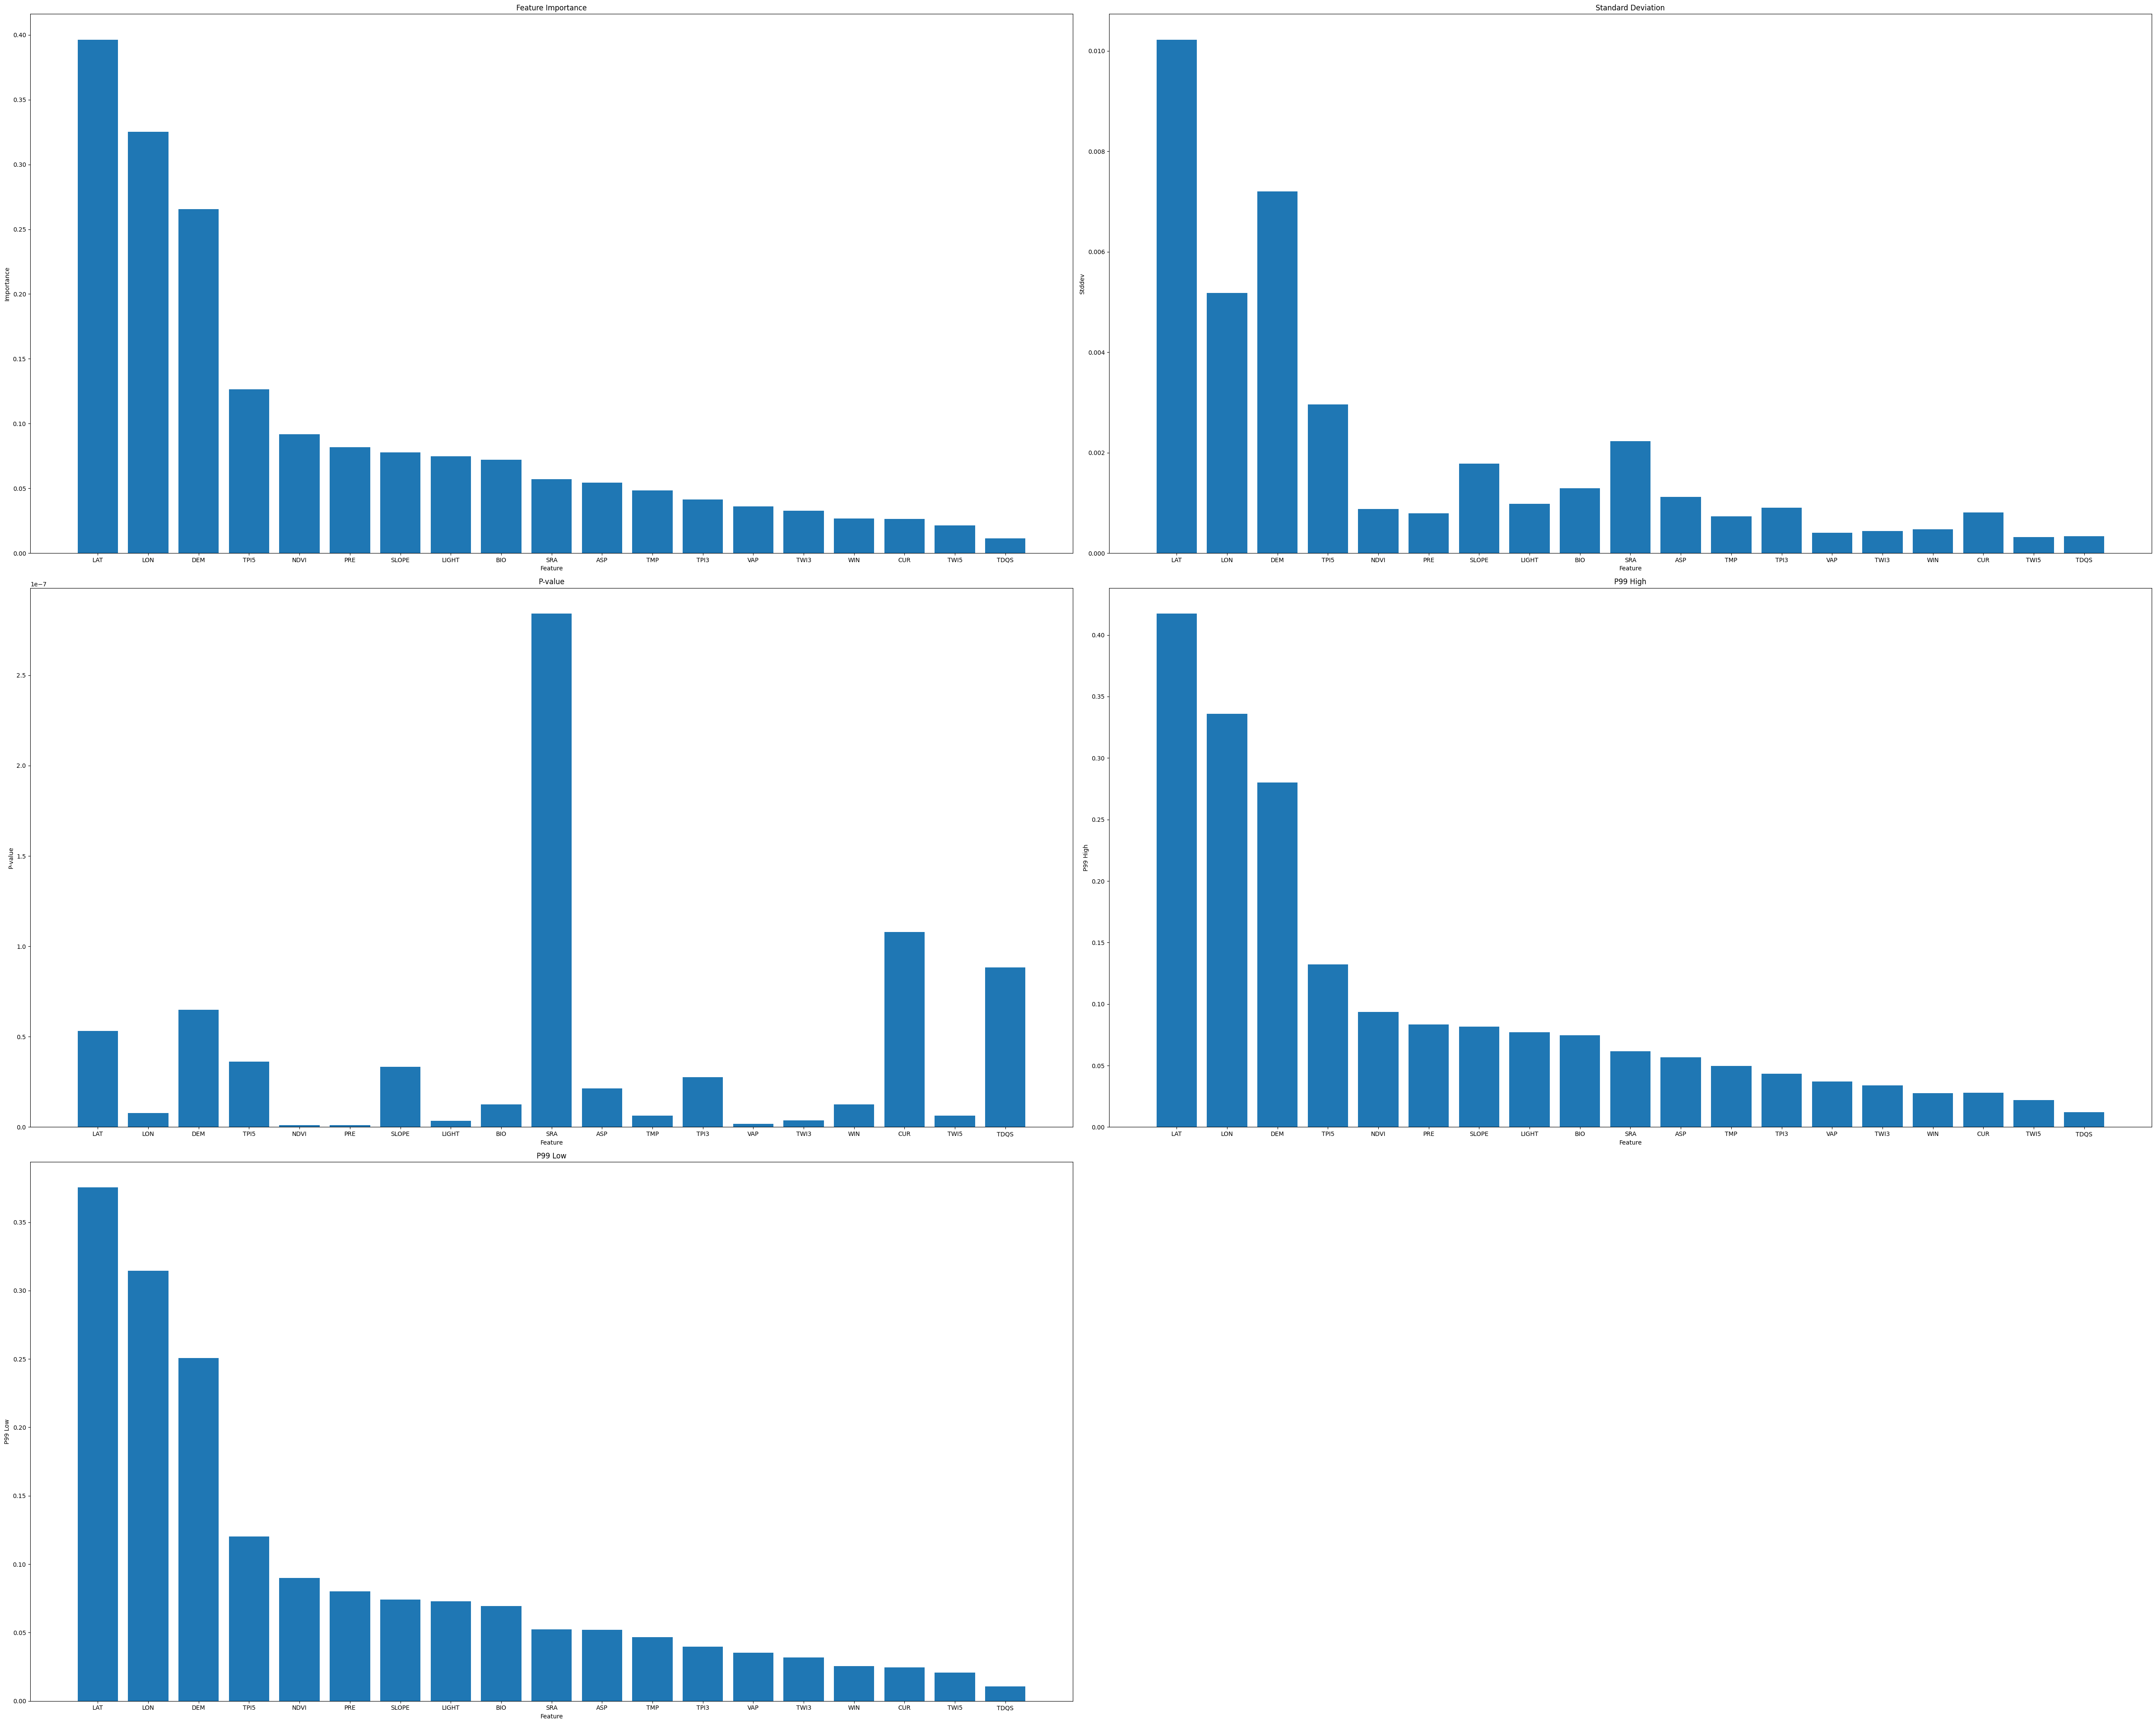

In [57]:
import matplotlib.pyplot as plt

# 设置图表大小
plt.figure(figsize=(50, 40))

# 绘制各个特征的重要性
plt.subplot(3, 2, 1)
plt.bar(df['index'], df['importance'])
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')

# 绘制各个特征的标准差
plt.subplot(3, 2, 2)
plt.bar(df['index'], df['stddev'])
plt.title('Standard Deviation')
plt.xlabel('Feature')
plt.ylabel('Stddev')

# 绘制各个特征的p值
plt.subplot(3, 2, 3)
plt.bar(df['index'], df['p_value'])
plt.title('P-value')
plt.xlabel('Feature')
plt.ylabel('P-value')

# 绘制各个特征的p99高值
plt.subplot(3, 2, 4)
plt.bar(df['index'], df['p99_high'])
plt.title('P99 High')
plt.xlabel('Feature')
plt.ylabel('P99 High')

# 绘制各个特征的p99低值
plt.subplot(3, 2, 5)
plt.bar(df['index'], df['p99_low'])
plt.title('P99 Low')
plt.xlabel('Feature')
plt.ylabel('P99 Low')

# 调整子图之间的间距
plt.tight_layout()

# 展示图表
plt.show()

In [ ]:
"""importance（重要性）：

取值范围：通常是一个非负实数，可以是介于0到无穷大之间的任意值。
意义：表示该特征对目标变量的预测能力的贡献程度。重要性值越高，说明该特征在预测模型中的影响力越大。
stddev（标准差）：

取值范围：通常是一个非负实数，可以是大于等于0的任意值。
意义：衡量特征值分散程度的统计指标。标准差值越大，表示样本数据在该特征上的波动越大。
p_value（P值）：

取值范围：通常是一个小于等于1的实数，可能是非负实数或者在特定情况下限制在0到1之间的实数。
意义：用于判断某个变量对目标变量是否具有显著影响。较小的p-value表示该特征与目标变量之间的关系更显著。
n（样本数量）：

取值范围：通常是一个正整数，表示用于计算这些特征参数的样本数量。
意义：表示用于计算特征参数的数据样本的数量。
p99_high（99%置信度上限）和p99_low（99%置信度下限）：

取值范围：通常是实数，可以是任意实数或在特定情况下限制在一定范围内的实数。
意义：表示特征的置信区间。在统计意义下，特征取值不会超过上限或低于下限的概率为99%。"""

In [386]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score

In [59]:

from sklearn.preprocessing import StandardScaler
# 1. 划分数据为特征（X）和目标（y）
X = data.drop(columns=['pH'])
y = data['pH']

# 2. 划分数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((5112, 19), (1278, 19))

In [61]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score

# 建立神经网络模型
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 训练模型
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

# 使用模型进行预测
y_pred_nn = model.predict(X_test_scaled)

# 计算 R^2 分数
r2_nn = r2_score(y_test, y_pred_nn)

r2_nn


40/40 [==============================] - 0s 439us/step


0.19366889969938528